# <a id='toc1_'></a>[Исследование посетителей супермаркета](#toc0_)

## <a id='toc1_1_'></a>[Цель](#toc0_)
Провести комплексный многоаспектный анализ данных о посетителях супермаркета с целью выявления скрытых закономерностей в демографических характеристиках, уровне дохода и покупательском поведении. Исследование включает сегментацию клиентов, изучение взаимосвязей между ключевыми переменными (возраст, доход, затраты и пол) и разработку прогностических моделей для поддержки решений в маркетинге и развития клиентской базы.

## <a id='toc1_2_'></a>[Вопросы](#toc0_)
1. На какие сегменты можно разделить клиентов супермаркета?
2. Какие зависимости существуют между возрастом, уровнем дохода и тратами клиентов?
3. Как влияет пол на распределение доходов и покупательских оценок?
4. Можно ли создать надёжную прогностическую модель для оценки Spending Score на основе возраста, уровня дохода и пола? Какие факторы являются наиболее значимыми?
5. Какие аномалии и выбросы присутствуют в данных, и как они могут влиять на результаты анализа?

## <a id='toc1_3_'></a>[Описание](#toc0_)
Для проведения исследования был взят следующий набор данных:
https://www.kaggle.com/datasets/vjchoudhary7/customer-segmentation-tutorial-in-python

Есть супермаркет и с помощью членских карт мы получаем некоторые базовые данные о своих клиентах, такие как идентификатор клиента, возраст, пол, годовой доход и рейтинг расходов.
Рейтинг расходов — это показатель, который вы присваиваете клиенту на основе заданных вами параметров, таких как поведение клиента и данные о покупках.

**Содержание:**<a id='toc0_'></a>    
- [Исследование посетителей супермаркета](#toc1_)    
  - [Цель](#toc1_1_)    
  - [Вопросы](#toc1_2_)    
  - [Описание](#toc1_3_)    
- [Обзор данных](#toc2_)    
  - [Обзор таблицы](#toc2_1_)    
  - [Диагностика данных](#toc2_2_)    
- [Визуализация данных](#toc3_)    
  - [Диаграммы распределения значений полей](#toc3_1_)    
  - [Диаграмма распределения значений по половому признаку](#toc3_2_)    
  - [Графики зависимостей между возрастом, годовым доходом и показателем расходов](#toc3_3_)    
  - [График распределения годового дохода в зависимости от возраста и пола](#toc3_4_)    
  - [График распределения показателя расходов в зависимости от возраста и пола](#toc3_5_)    
  - [График распределения показателя расходов в зависимости от годового дохода и пола](#toc3_6_)    
  - [Диаграммы с распределением значений по возрасту, доходу и расходам в зависимости от пола](#toc3_7_)    
- [Вопрос 1. На какие сегменты можно разделить клиентов супермаркета?](#toc4_)    
  - [Сегментация с использованием оценки возраста и расходов](#toc4_1_)    
    - [Разделение посетителей на 3 сегмента](#toc4_1_1_)    
    - [Разделение посетителей на 4 сегмента](#toc4_1_2_)    
    - [Разделение посетителей на 5 сегментов](#toc4_1_3_)    
  - [Сегментация с использованием оценки годового дохода и расходов](#toc4_2_)    
    - [Разделение посетителей оптимально на 5 сегментов](#toc4_2_1_)    
- [Вопрос 2. Какие зависимости существуют между возрастом, уровнем дохода и тратами клиентов?](#toc5_)    
  - [Корреляционная матрица между возрастом, уровнем годового дохода и показателем расходов](#toc5_1_)    
  - [Тепловая карта на основании корреляционной матрицы](#toc5_2_)    
- [Вопрос 3. Как влияет пол на распределение доходов и покупательских оценок?](#toc6_)    
  - [Сводная таблица по половому признаку](#toc6_1_)    
  - [Детальная статистика распределения доходов и расходов по половому признаку](#toc6_2_)    
  - [Ящик с усами с распределением доходов и расходов по полу](#toc6_3_)    
  - [Скрипичная диаграмма с распределением доходов и расходов по полу](#toc6_4_)    
  - [Интерактивная гистограмма с распределением доходов и расходов по полу](#toc6_5_)    
- [Вопрос 4. Можно ли создать надёжную прогностическую модель для оценки показателя расходов на основе возраста, уровня дохода и пола? Какие факторы являются наиболее значимыми?](#toc7_)    
  - [Базовая модель: Линейная регрессия](#toc7_1_)    
  - [Сложная модель: Random Forest Regressor](#toc7_2_)    
  - [Анализ важности признаков для Random Forest](#toc7_3_)    
  - [График для линейной регрессии истинного и предсказанного значения](#toc7_4_)    
  - [График распределения остатков для линейной модели](#toc7_5_)    
  - [Дополнительно: Кросс-валидация для оценки устойчивости линейной модели](#toc7_6_)    
- [Вопрос 5. Какие аномалии и выбросы присутствуют в данных, и как они могут влиять на результаты анализа?](#toc8_)    
  - [Определение выбросов для каждой переменной](#toc8_1_)    
  - [Ящик с усами для демонстрации выбросов](#toc8_2_)    
  - [График распределения для выделения выбросов показателя расходов относительно доходов](#toc8_3_)    
  - [Выделение точек-выбросов для годового дохода](#toc8_4_)    
- [Итоги](#toc9_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc2_'></a>[Обзор данных](#toc0_)
Проведём обзор данных с целью понять их структуру и проверить наличие ошибок

Импортируем библиотеки и определим функцию для диагностики данных в dataframe

In [361]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('data\mall_customers.csv', sep = ',')

# функция для диагностики df
def df_diagnostics(df):
    # Собираем основные характеристики столбцов
    diag = pd.DataFrame({'dtypes': df.dtypes, 'count': df.count(), 'unique': df.nunique(),
                         'NaN count': df.isnull().sum(), 'NaN percentage': df.isnull().sum() / df.shape[0]})
    
    # Словарь описывающий, какую функцию применить для каждой метрики
    metrics = {'mean': lambda s: s.mean(), 'median': lambda s: s.median(), 'std': lambda s: s.std(),
               'min':  lambda s: s.min(),  'max':    lambda s: s.max()}
    
    # Вычисляем метрики для каждого столбца
    for metric, func in metrics.items():
        diag[metric] = [func(df[col]) if pd.api.types.is_numeric_dtype(df[col]) else np.nan 
                        for col in df.columns]
    
    # Вычисляем количество дублирующих строк в df
    duplicates_count = df.duplicated().sum()
    print("Количество дублирующих строк:", duplicates_count)
    return diag.style.background_gradient(cmap='Set3', low=0.1, high=0.01)

## <a id='toc2_1_'></a>[Обзор таблицы](#toc0_)

In [362]:
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


## <a id='toc2_2_'></a>[Диагностика данных](#toc0_)

In [363]:
df_diagnostics(df)

Количество дублирующих строк: 0


,dtypes,count,unique,NaN count,NaN percentage,mean,median,std,min,max
CustomerID,int64,200,200,0,0.000000,100.500000,100.500000,57.879185,1.000000,200.000000
Gender,object,200,2,0,0.000000,nan,nan,nan,nan,nan
Age,int64,200,51,0,0.000000,38.850000,36.000000,13.969007,18.000000,70.000000
Annual Income (k$),int64,200,64,0,0.000000,60.560000,61.500000,26.264721,15.000000,137.000000
Spending Score (1-100),int64,200,84,0,0.000000,50.200000,50.000000,25.823522,1.000000,99.000000


Диагностика данных в таблице показала:
- дублирующих строк нет
- имена полей корректны
- типы данных соответствуют
- все клиенты по полю `CustomerID` уникальные
- пропусков данных в полях нет
- данные о возрасте клиентов `Age` в диапазоне от 18 до 70
- данные о годовом доходе `Annual Income (k$)` в диапазоне от 15 до 137 k$
- данные о показателе расходов `Spending Score (1-100)` в диапазоне от 1 до 99

# <a id='toc3_'></a>[Визуализация данных](#toc0_)

Выполним визуализацию данных для лучшего понимания их структуры

## <a id='toc3_1_'></a>[Диаграммы распределения значений полей](#toc0_)

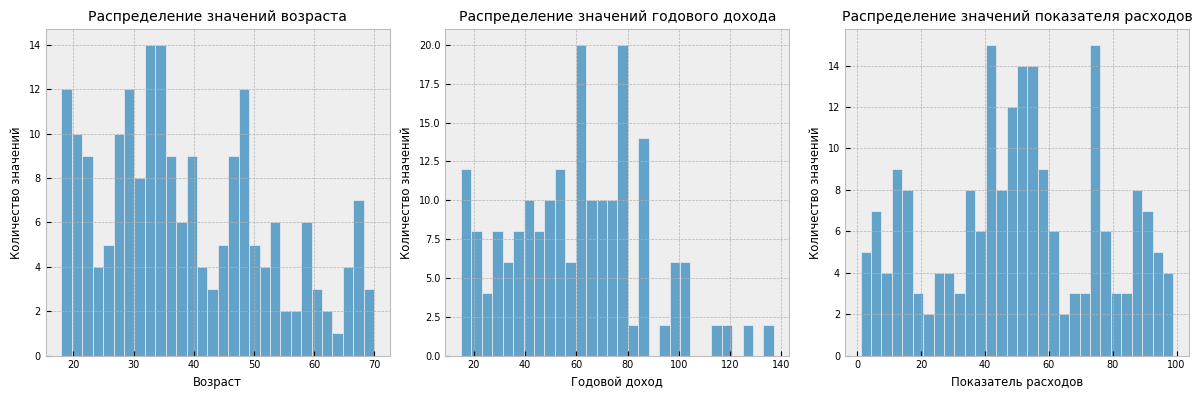

In [364]:
# стиль графиков и глобальный размер шрифта
plt.style.use('bmh')
plt.rc('font', size=7)

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
sns.histplot(df['Age'], bins=30)
plt.title("Распределение значений возраста")
plt.xlabel("Возраст"), plt.ylabel("Количество значений")

plt.subplot(1, 3, 2)
sns.histplot(df['Annual Income (k$)'], bins=30)
plt.title("Распределение значений годового дохода")
plt.xlabel("Годовой доход"), plt.ylabel("Количество значений")

plt.subplot(1, 3, 3)
sns.histplot(df['Spending Score (1-100)'], bins=30)
plt.title("Распределение значений показателя расходов")
plt.xlabel("Показатель расходов"), plt.ylabel("Количество значений")

plt.tight_layout()
plt.show()

## <a id='toc3_2_'></a>[Диаграмма распределения значений по половому признаку](#toc0_)

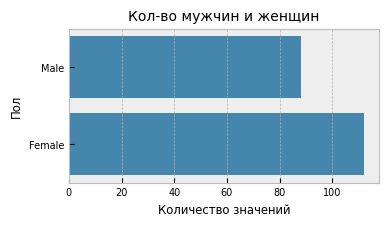

In [365]:
plt.figure(figsize = (4, 2))
sns.countplot(y = 'Gender' , data = df)
plt.xlabel('Количество значений'), plt.ylabel('Пол')
plt.title('Кол-во мужчин и женщин')
plt.show()

## <a id='toc3_3_'></a>[Графики зависимостей между возрастом, годовым доходом и показателем расходов](#toc0_)

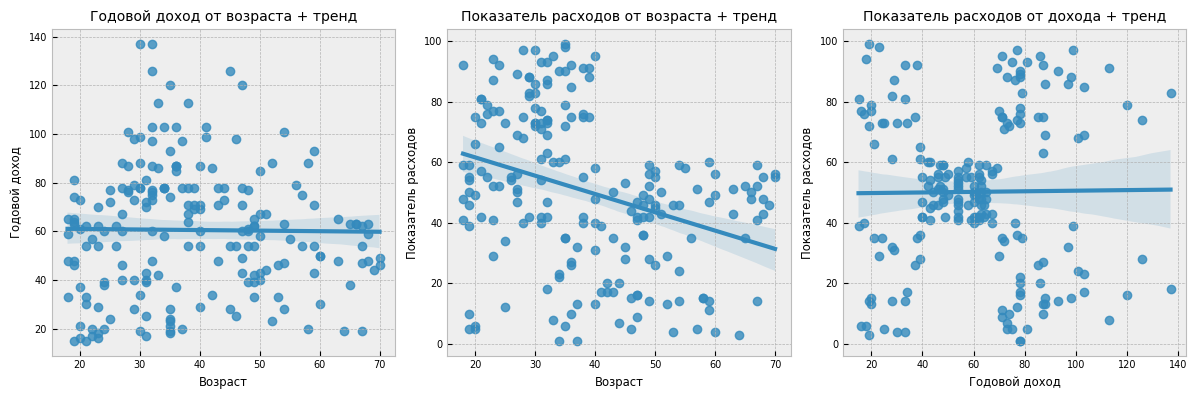

In [366]:
plt.figure(figsize = (12, 4))

plt.subplot(1, 3, 1)
sns.regplot(data = df, x = 'Age', y = 'Annual Income (k$)')
plt.title("Годовой доход от возраста + тренд")
plt.xlabel("Возраст"), plt.ylabel("Годовой доход")

plt.subplot(1, 3, 2)
sns.regplot(data = df, x = 'Age', y = 'Spending Score (1-100)')
plt.title("Показатель расходов от возраста + тренд")
plt.xlabel("Возраст"), plt.ylabel("Показатель расходов")

plt.subplot(1, 3, 3)
sns.regplot(data = df, x = 'Annual Income (k$)', y = 'Spending Score (1-100)')
plt.title("Показатель расходов от дохода + тренд")
plt.xlabel("Годовой доход"), plt.ylabel("Показатель расходов")

plt.tight_layout()
plt.show()

## <a id='toc3_4_'></a>[График распределения годового дохода в зависимости от возраста и пола](#toc0_)

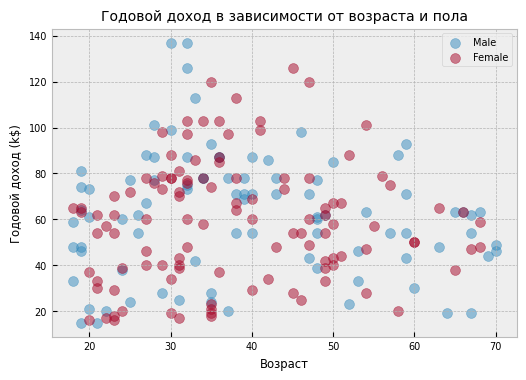

In [367]:
plt.figure(figsize = (6, 4))

for gender in ['Male', 'Female']:
    plt.scatter(x = 'Age', y = 'Annual Income (k$)', data = df[df['Gender'] == gender],
                s = 50, alpha = 0.5, label = gender)
    
plt.title('Годовой доход в зависимости от возраста и пола')
plt.xlabel('Возраст'), plt.ylabel('Годовой доход (k$)')
plt.legend()
plt.show()

## <a id='toc3_5_'></a>[График распределения показателя расходов в зависимости от возраста и пола](#toc0_)

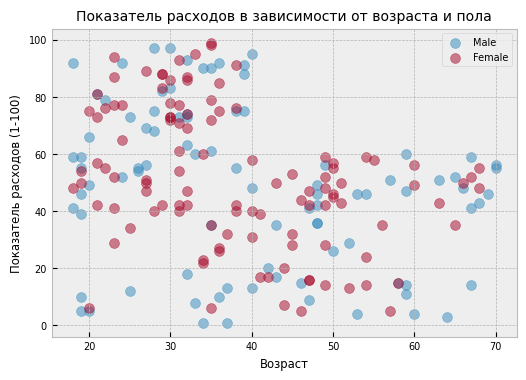

In [368]:
plt.figure(figsize = (6, 4))

for gender in ['Male', 'Female']:
    plt.scatter(x = 'Age', y = 'Spending Score (1-100)', data = df[df['Gender'] == gender],
                s = 50, alpha = 0.5, label = gender)
    
plt.title('Показатель расходов в зависимости от возраста и пола')
plt.xlabel('Возраст'), plt.ylabel('Показатель расходов (1-100)')
plt.legend()
plt.show()

## <a id='toc3_6_'></a>[График распределения показателя расходов в зависимости от годового дохода и пола](#toc0_)

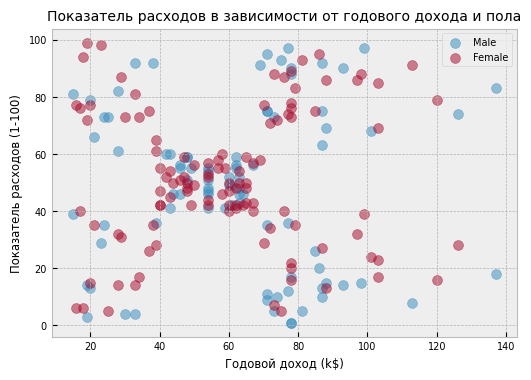

In [369]:
plt.figure(figsize = (6, 4))

for gender in ['Male', 'Female']:
    plt.scatter(x = 'Annual Income (k$)', y = 'Spending Score (1-100)',
                data = df[df['Gender'] == gender], s = 50, alpha = 0.5, label = gender)
    
plt.title('Показатель расходов в зависимости от годового дохода и пола')
plt.xlabel('Годовой доход (k$)'), plt.ylabel('Показатель расходов (1-100)')
plt.legend()
plt.show()

## <a id='toc3_7_'></a>[Диаграммы с распределением значений по возрасту, доходу и расходам в зависимости от пола](#toc0_)

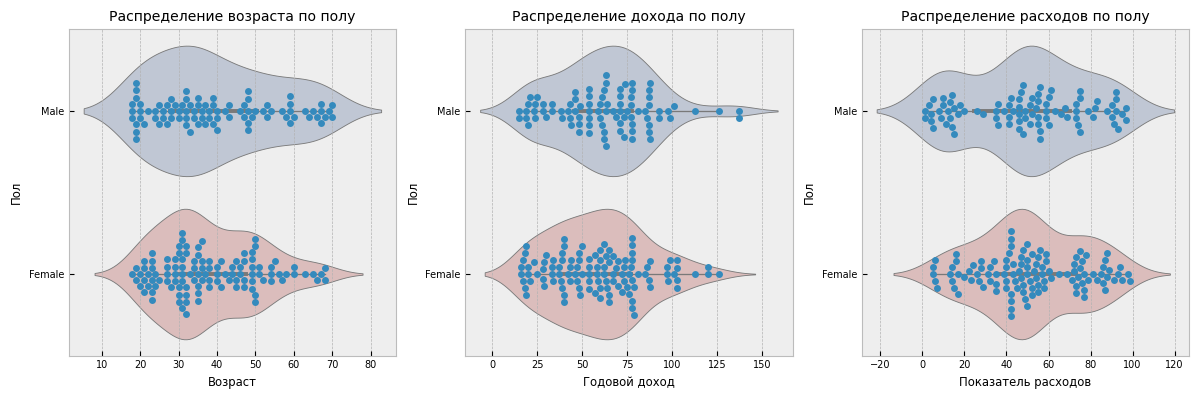

In [370]:
plt.figure(figsize = (12, 4))

plt.subplot(1, 3, 1)
sns.violinplot(x='Age', y='Gender', data=df, hue='Gender', palette='vlag', legend=False)
sns.swarmplot(x='Age', y='Gender', data=df)
plt.title('Распределение возраста по полу')
plt.xlabel('Возраст'), plt.ylabel('Пол')

plt.subplot(1, 3, 2)
sns.violinplot(x='Annual Income (k$)', y='Gender', data=df, hue='Gender', palette='vlag', legend=False)
sns.swarmplot(x='Annual Income (k$)', y='Gender', data=df)
plt.title('Распределение дохода по полу')
plt.xlabel('Годовой доход'), plt.ylabel('Пол')

plt.subplot(1, 3, 3)
sns.violinplot(x='Spending Score (1-100)', y='Gender', data=df, hue='Gender', palette='vlag', legend=False)
sns.swarmplot(x='Spending Score (1-100)', y='Gender', data=df)
plt.title('Распределение расходов по полу')
plt.xlabel('Показатель расходов'), plt.ylabel('Пол')

plt.tight_layout()
plt.show()

<a id='link_1'></a>
# <a id='toc4_'></a>[Вопрос 1. На какие сегменты можно разделить клиентов супермаркета?](#toc0_)

Для сегментирования клиентов супермаркета выполним разделение клиентов на сегменты с помощью кластеризации методом `К-средних`

Импортируем необходимые библиотеки и внесём определения функций для определения числа кластеров и построения кластеров

In [371]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

def selecting_number_clusters(transf, n_clusters = range(2, 9), init = 'k-means++', n_init = 'auto',
                              tol = 0.0001, max_iter = 300, algorithm = 'lloyd', random_state = None):
    """
    Функция для определения числа кластеров.
    Большинство параметров ретранслируется в метод KMeans() для управления подбора параметров в цикле.
    Определение оптимального числа кластеров происходит путем поиска точки перегиба на графике инерции.
    """

    # если в модель переданы в ручную установленные центроиды, то n_init = 1
    if init not in ['k-means++', 'random']:
        n_init = 1
    
    inertia = []

    for k in n_clusters:
        kmeans = KMeans(n_clusters = k, init = init, n_init = n_init, tol = tol, max_iter = max_iter,
                        algorithm = algorithm, random_state = random_state).fit(transf)
        inertia.append(kmeans.inertia_)

    # Выведем график
    plt.figure(figsize = (6, 4))
    plt.plot(n_clusters, inertia, marker='o')
    plt.title(f'Зависимость инерции от кол-ва кластеров.')
    plt.xlabel('Число кластеров'), plt.ylabel('Инерция')
    plt.show()
    return None
    
def building_clusters(df, column_name, column_label, transf, scaler, n_clusters, init = 'k-means++',
                      n_init = 'auto', tol = 0.0001, max_iter = 300, algorithm = 'lloyd',
                      random_state = None, note = None):
    """
    Функция для построения кластеров.
    :param df: df для построения графика.
    :param column_name: список с именами столбцов в df.
    :param column_label: список как назвать оси на графике.
    :param transf и scaler: для модели сегментации.
    :param note: вывод параметров модели в заголовок графика. Для информирования во время перебора и подбора параметров.
    Остальные параметры перенаправляются в метод KMeans() для управления подбора параметров в цикле.
    """

    # если в модель переданы в ручную установленные центры центроид, то n_init = 1
    if init not in ['k-means++', 'random']:
        n_init = 1

    x_column = column_name[0]
    y_column = column_name[1]
    x_labels = column_label[0]
    y_labels = column_label[1]
    
    # Создаём модель KMeans с кластерами
    kmeans = KMeans(n_clusters = n_clusters, init = init, n_init = n_init, tol = tol, max_iter = max_iter,
                    algorithm = algorithm, random_state = random_state).fit(transf)
    
    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_

    # Переводим центроиды обратно в исходное пространство
    centroids_orig = scaler.inverse_transform(centroids)

    # Создаём сетку в исходном (оригинальном) пространстве
    h = 0.5  # шаг сетки
    x_min = df[x_column].min() - 1
    x_max = df[x_column].max() + 1
    y_min = df[y_column].min() - 1
    y_max = df[y_column].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # Преобразуем сетку в стандартизированное пространство и делаем предсказание
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    grid_points_scaled = scaler.transform(grid_points)
    Z = kmeans.predict(grid_points_scaled)
    Z = Z.reshape(xx.shape)

    # Строим график
    fig, ax = plt.subplots(figsize = (6, 4))
    ax.imshow(Z, interpolation='nearest', extent=(x_min, x_max, y_min, y_max),
              cmap=plt.cm.Pastel2, aspect='auto', origin='lower')

    # Отображаем исходные данные, центроиды и границы кластеров
    ax.scatter(df[x_column], df[y_column], c=labels, s=30)
    ax.scatter(centroids_orig[:, 0], centroids_orig[:, 1], s=100, c='red', alpha=0.5)
    
    # Текст заголовка
    if note != None:
        title_text = f"Кластеров: {n_clusters}. {note}"
    else:
        title_text = f"Разделение посетителей на {n_clusters} кластера"
    
    # Добавляем заголовок и подписываем оси
    ax.set_title(title_text)
    ax.set_xlabel(x_labels), ax.set_ylabel(y_labels)
    plt.show()
    return None

## <a id='toc4_1_'></a>[Сегментация с использованием оценки возраста и расходов](#toc0_)

Выполним подготовку данных и выведем график зависимости инерции от количества кластеров

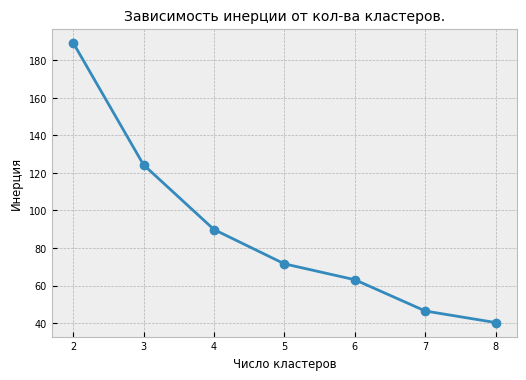

In [372]:
spend_features = df[['Age', 'Spending Score (1-100)']].values
spend_scaler = StandardScaler()
spend_transf = spend_scaler.fit_transform(spend_features)

selecting_number_clusters(transf = spend_transf)

Разделение посетителей оптимально на 3, 4 и 5 сегментов

Далее подбором параметров были определены следующие варианты сегментации

### <a id='toc4_1_1_'></a>[Разделение посетителей на 3 сегмента](#toc0_)

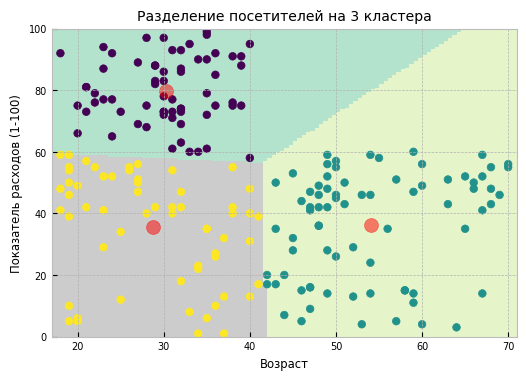

In [373]:
building_clusters(df = df, column_name = ['Age', 'Spending Score (1-100)'],
                  column_label = ['Возраст', 'Показатель расходов (1-100)'],
                  transf = spend_transf, scaler = spend_scaler, n_clusters = 3, random_state = 34)

### <a id='toc4_1_2_'></a>[Разделение посетителей на 4 сегмента](#toc0_)

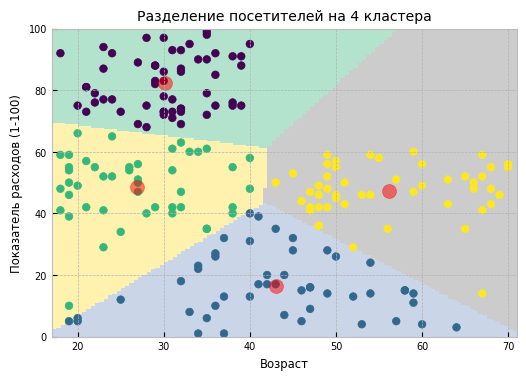

In [374]:
building_clusters(df = df, column_name = ['Age', 'Spending Score (1-100)'],
                  column_label = ['Возраст', 'Показатель расходов (1-100)'],
                  transf = spend_transf, scaler = spend_scaler, n_clusters = 4, tol=0.00001, random_state = 4)

### <a id='toc4_1_3_'></a>[Разделение посетителей на 5 сегментов](#toc0_)

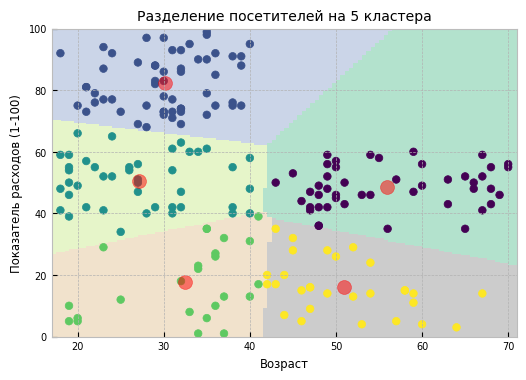

In [375]:
building_clusters(df = df, column_name = ['Age', 'Spending Score (1-100)'],
                  column_label = ['Возраст', 'Показатель расходов (1-100)'],
                  transf = spend_transf, scaler = spend_scaler, n_clusters = 5, tol=0.00001, random_state = 20)

## <a id='toc4_2_'></a>[Сегментация с использованием оценки годового дохода и расходов](#toc0_)

Выполним подготовку данных и выведем график зависимости инерции от количества кластеров

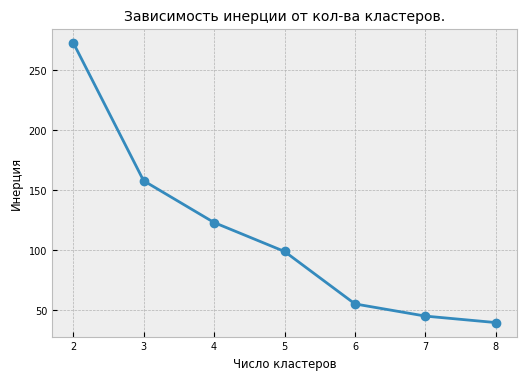

In [376]:
annual_features = df[['Annual Income (k$)', 'Spending Score (1-100)']].values
annual_scaler = StandardScaler()
annual_transf = annual_scaler.fit_transform(annual_features)

selecting_number_clusters(transf = annual_transf)

### <a id='toc4_2_1_'></a>[Разделение посетителей оптимально на 5 сегментов](#toc0_)

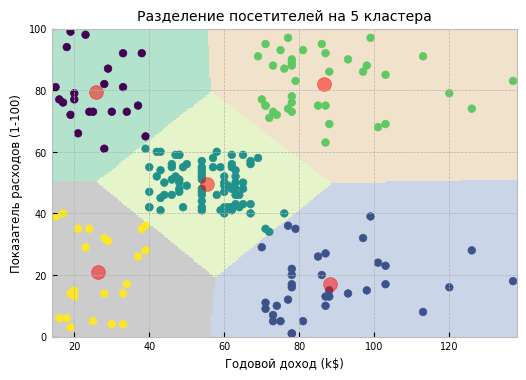

In [377]:
building_clusters(df = df, column_name = ['Annual Income (k$)', 'Spending Score (1-100)'],
                  column_label = ['Годовой доход (k$)', 'Показатель расходов (1-100)'],
                  transf = annual_transf, scaler = annual_scaler, n_clusters = 5)

**Вывод:** Клиентов супермаркета можно разделить с использованием оценки возраста и расходов на 3, 4 и 5 сегментов. Клиентов супермаркета также можно разделить с использованием оценки годового дохода и расходов на 5 сегментов.

<a id='link_2'></a>
# <a id='toc5_'></a>[Вопрос 2. Какие зависимости существуют между возрастом, уровнем дохода и тратами клиентов?](#toc0_)

## <a id='toc5_1_'></a>[Корреляционная матрица между возрастом, уровнем годового дохода и показателем расходов](#toc0_)

In [378]:
corr_matrix = df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']].corr()
print("Корреляционная матрица:\n", corr_matrix)

Корреляционная матрица:
                              Age  Annual Income (k$)  Spending Score (1-100)
Age                     1.000000           -0.012398               -0.327227
Annual Income (k$)     -0.012398            1.000000                0.009903
Spending Score (1-100) -0.327227            0.009903                1.000000


Расшифровка корреляционной матрицы:
- Возраст (Age) и Годовой Доход (Annual Income):
Коэффициент корреляции равен -0.012398. Это значит, что практически отсутствует какая-либо значимая связь между возрастом и годовым доходом. С увеличением возраста доходы снижаются не значительно.

- Возраст (Age) и Показатель Расходов (Spending Score):
Коэффициент корреляции составляет -0.327227, что свидетельствует о слабой отрицательной зависимости. Это означает, что с увеличением возраста расходы немного снижаются. То есть, чем старше человек, тем ниже его уровень трат.

- Годовой Доход (Annual Income) и Показатель Расходов (Spending Score):
Значение корреляции равно 0.009903, что также указывает на почти полное отсутствие связи. Получается, что увеличение доходов слабо связано с ростом уровня расходов. Люди с большим доходом не обязательно больше тратят.

## <a id='toc5_2_'></a>[Тепловая карта на основании корреляционной матрицы](#toc0_)

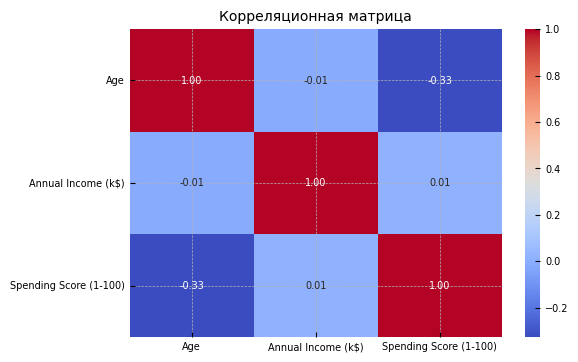

In [379]:
plt.figure(figsize = (6, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Корреляционная матрица")
plt.show()

**Вывод:** Зависимость между возрастом и годовым доходом практически отсутствует. С увеличением возраста доходы снижаются не значительно. Зависимость между возрастом и показателем расходов слабая отрицательная. Это означает, что с увеличением возраста расходы немного снижаются. Между годовым доходом и показателем расходов зависимость практически отсутствует.

<a id='link_3'></a>
# <a id='toc6_'></a>[Вопрос 3. Как влияет пол на распределение доходов и покупательских оценок?](#toc0_)

## <a id='toc6_1_'></a>[Сводная таблица по половому признаку](#toc0_)

In [380]:
print("Средние значения `годового дохода` и `показателя расходов` по полу:")
print(df.groupby('Gender')[['Annual Income (k$)', 'Spending Score (1-100)']].mean())

Средние значения `годового дохода` и `показателя расходов` по полу:
        Annual Income (k$)  Spending Score (1-100)
Gender                                            
Female           59.250000               51.526786
Male             62.227273               48.511364


Разъяснение показателей в таблице:
1. Годовой доход:
   - Женщины имеют средний годовой доход около 59,25 тысяч долларов.
   - Мужчины имеют немного больший средний доход — примерно 62,23 тысячи долларов.
   
   Это означает, что мужчины зарабатывают чуть больше, чем женщины, хотя разница невелика.

2. Уровень расходов (по шкале от 1 до 100):
   - Средний уровень расходов среди женщин составляет 51,53.
   - Среди мужчин этот показатель ниже — 48,51.

   Таким образом, женщины тратят немного больше денег, чем мужчины.

Возможная интерпретация:
- Несмотря на то, что мужчины в среднем зарабатывают больше, женщины склонны тратить больше относительно своего дохода. Это может указывать на различия в покупательских привычках или предпочтениях между полами.

## <a id='toc6_2_'></a>[Детальная статистика распределения доходов и расходов по половому признаку](#toc0_)

In [381]:
print("Детальная статистика:")
print(df.groupby('Gender')[['Annual Income (k$)', 'Spending Score (1-100)']].describe())

Детальная статистика:
       Annual Income (k$)                                                  \
                    count       mean        std   min    25%   50%    75%   
Gender                                                                      
Female              112.0  59.250000  26.011952  16.0  39.75  60.0  77.25   
Male                 88.0  62.227273  26.638373  15.0  45.50  62.5  78.00   

              Spending Score (1-100)                                        \
          max                  count       mean       std  min   25%   50%   
Gender                                                                       
Female  126.0                  112.0  51.526786  24.11495  5.0  35.0  50.0   
Male    137.0                   88.0  48.511364  27.89677  1.0  24.5  50.0   

                    
         75%   max  
Gender              
Female  73.0  99.0  
Male    70.0  97.0  


## <a id='toc6_3_'></a>[Ящик с усами с распределением доходов и расходов по полу](#toc0_)

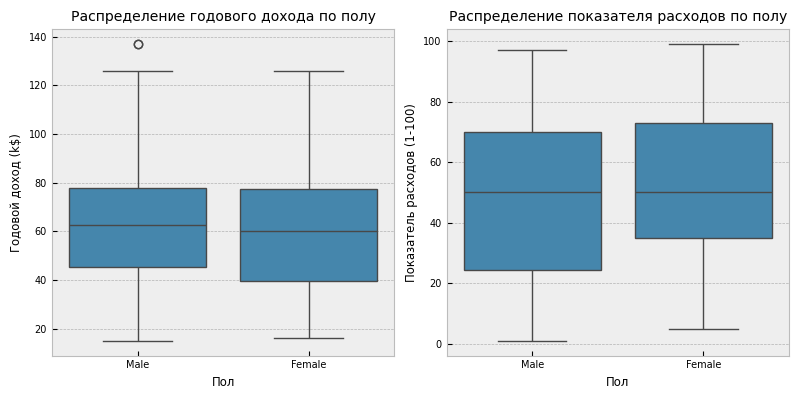

In [382]:
plt.figure(figsize = (8, 4))

plt.subplot(1, 2, 1)
sns.boxplot(x='Gender', y='Annual Income (k$)', data=df)
plt.title('Распределение годового дохода по полу')
plt.xlabel('Пол'), plt.ylabel('Годовой доход (k$)')

plt.subplot(1, 2, 2)
sns.boxplot(x='Gender', y='Spending Score (1-100)', data=df)
plt.title('Распределение показателя расходов по полу')
plt.xlabel('Пол'), plt.ylabel('Показатель расходов (1-100)')

plt.tight_layout()
plt.show()

## <a id='toc6_4_'></a>[Скрипичная диаграмма с распределением доходов и расходов по полу](#toc0_)

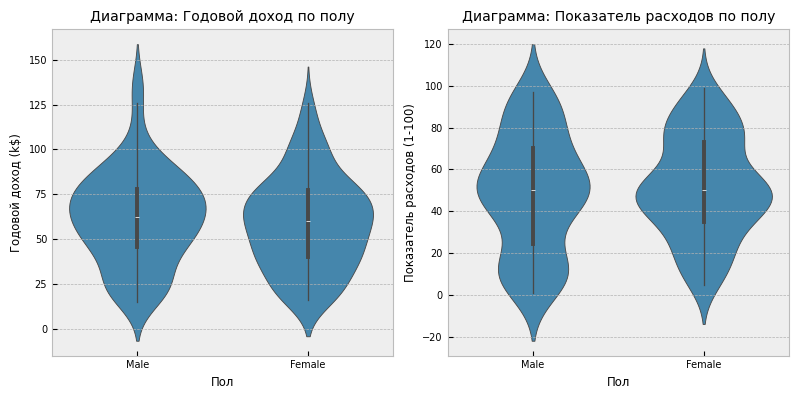

In [383]:
plt.figure(figsize = (8, 4))

plt.subplot(1, 2, 1)
sns.violinplot(x='Gender', y='Annual Income (k$)', data=df)
plt.title('Диаграмма: Годовой доход по полу')
plt.xlabel('Пол'), plt.ylabel('Годовой доход (k$)')

plt.subplot(1, 2, 2)
sns.violinplot(x='Gender', y='Spending Score (1-100)', data=df)
plt.title('Диаграмма: Показатель расходов по полу')
plt.xlabel('Пол'), plt.ylabel('Показатель расходов (1-100)')

plt.tight_layout()
plt.show()

## <a id='toc6_5_'></a>[Интерактивная гистограмма с распределением доходов и расходов по полу](#toc0_)

In [384]:
import plotly.express as px

fig = px.histogram(df, x="Annual Income (k$)", color="Gender", barmode='overlay',
                   opacity=0.75, title="Распределение годового дохода по полу")
fig.show()

fig = px.histogram(df, x="Spending Score (1-100)", color="Gender", barmode='overlay',
                   opacity=0.75, title="Распределение показателя расходов по полу")
fig.show()

**Вывод:** Женщины имеют средний годовой доход около 59,25 тысяч долларов и мужчины имеют немного больший средний доход примерно 62,23 тысячи долларов. Это означает, что мужчины зарабатывают немного больше, чем женщины. Средний уровень расходов среди женщин равен 51,53 и среди мужчин показатель ниже и равен 48,51. Это означает, что женщины тратят немного больше денег, чем мужчины.

<a id='link_4'></a>
# <a id='toc7_'></a>[Вопрос 4. Можно ли создать надёжную прогностическую модель для оценки показателя расходов на основе возраста, уровня дохода и пола? Какие факторы являются наиболее значимыми?](#toc0_)

Импортируем необходимые библиотеки и выполним предобработку данных

In [385]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler

# Создание копии DataFrame для моделирования
df_model = df.copy()

# Кодирование переменной Gender
df_model['Gender'] = df_model['Gender'].apply(lambda x: 1 if x == 'Male' else 0)

# Выбор признаков (X) и целевой переменной (y)
X = df_model[['Age', 'Annual Income (k$)', 'Gender']]
y = df_model['Spending Score (1-100)']

# Разбивка на обучающую и тестовую выборки (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Стандартизация признаков для линейной регрессии
scaler_model = StandardScaler()
X_train_scaled = scaler_model.fit_transform(X_train)
X_test_scaled = scaler_model.transform(X_test)

## <a id='toc7_1_'></a>[Базовая модель: Линейная регрессия](#toc0_)

In [386]:
lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_train)
y_pred_lin = lin_reg.predict(X_test_scaled)

print("Линейная регрессия:")
print("R²:", r2_score(y_test, y_pred_lin))
print("MAE:", mean_absolute_error(y_test, y_pred_lin))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lin)))

Линейная регрессия:
R²: 0.025478181600745997
MAE: 18.151395326685105
RMSE: 21.924259205438346


Показатели модели линейной регрессии указывают на её низкую точность прогнозирования Spending Score на основе выбранных факторов (возраст, уровень дохода и пол):

- Коэффициент детерминации R²: значение 0.02 означает, что всего лишь около 2% вариации целевой переменной объясняется моделью. Это крайне низкий показатель.
  
- Средняя абсолютная ошибка (MAE) равна примерно 18 единицам шкалы Spending Score. Это значит, что в среднем предсказания отклоняются от реальных значений на 18 пунктов.
  
- Корень среднеквадратичной ошибки (RMSE) составляет почти 22 единицы, что также подтверждает значительную ошибку прогноза.

Простая интерпретация: Модель плохо справляется с задачей — она объясняет менее 2% изменений в расходах клиентов, а её прогнозы часто далеки от истинных значений. Основные признаки, вероятно, недостаточно сильно связаны с целевым показателем.

## <a id='toc7_2_'></a>[Сложная модель: Random Forest Regressor](#toc0_)

In [387]:
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_reg.fit(X_train, y_train)
y_pred_rf = rf_reg.predict(X_test)

print("Random Forest Regression:")
print("R²:", r2_score(y_test, y_pred_rf))
print("MAE:", mean_absolute_error(y_test, y_pred_rf))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))

Random Forest Regression:
R²: 0.07749115042457333
MAE: 12.371279166666667
RMSE: 21.331157140778448


Модель случайного леса (Random Forest) показывает немного лучшие результаты по сравнению с линейной регрессией, но всё ещё остаётся недостаточно точной:

- Коэффициент детерминации R²: 0.08 означает, что модель объясняет около 8% вариаций в Spending Score. Хотя это лучше, чем у линейной регрессии, этот результат всё равно считается низким.
  
- Средняя абсолютная ошибка (MAE) уменьшилась до 12 единиц, что говорит о меньшем среднем отклонении прогнозов от фактических значений.
  
- Корень среднеквадратичной ошибки (RMSE) остался практически таким же — около 21 единицы, что свидетельствует о значительной ошибке в прогнозировании.

Простая интерпретация: Случайный лес работает чуть лучше линейной регрессии, уменьшая среднюю ошибку прогноза. Однако модель всё равно остаётся ненадёжной, поскольку она объясняет лишь небольшую долю изменений в показателях расходов.

## <a id='toc7_3_'></a>[Анализ важности признаков для Random Forest](#toc0_)

In [388]:
importances = rf_reg.feature_importances_
feature_names = X.columns

print("Важность признаков (Random Forest):")
for name, importance in zip(feature_names, importances):
    print(f"Признак: {name}, Важность: {importance:.3f}")

Важность признаков (Random Forest):
Признак: Age, Важность: 0.494
Признак: Annual Income (k$), Важность: 0.474
Признак: Gender, Важность: 0.032


Анализ важности признаков для модели случайного леса (Random Forest) показывает вклад каждого признака в предсказание Spending Score:

- Возраст (Age): важность 0.49 указывает, что возраст является самым влиятельным фактором среди всех рассматриваемых признаков. Он оказывает наибольшее влияние на прогнозируемые расходы.
  
- Годовой доход (Annual Income): важность 0.47 также делает его важным признаком, который значительно влияет на прогноз.
  
- Пол (Gender): важность 0.03 демонстрирует, что пол играет наименьшую роль в предсказании расходов, его влияние минимально.

Простая интерпретация: Возраст и годовой доход оказывают значительное влияние на предсказываемый уровень расходов, тогда как пол практически не имеет значения для этой модели.

## <a id='toc7_4_'></a>[График для линейной регрессии истинного и предсказанного значения](#toc0_)

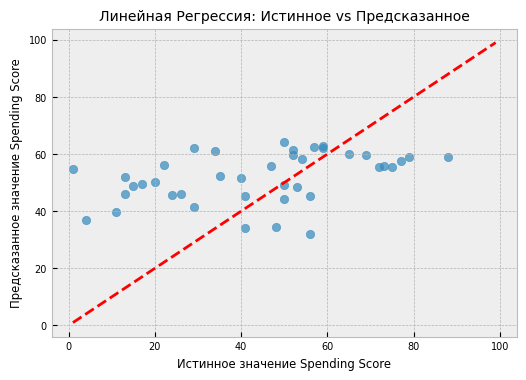

In [389]:
plt.figure(figsize = (6, 4))
plt.scatter(y_test, y_pred_lin, alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.title("Линейная Регрессия: Истинное vs Предсказанное")
plt.xlabel("Истинное значение Spending Score")
plt.ylabel("Предсказанное значение Spending Score")
plt.show()

График истинного и предсказанного значения отображает соответствие между реальными и предсказанными значениями Spending Score, полученными с помощью модели линейной регрессии. Красная пунктирная линия представляет идеальную ситуацию, когда предсказанные значения точно совпадают с истинными. Если точки плотно сгруппированы вдоль красной линии, это означает высокую точность модели: предсказания близки к реальным значениям.

Интерпретация графика: В нашем случае точки разбросаны далеко от красной линии, что указывает на слабую корреляцию между предсказаниями и реальностью. Значения метрик R², MAE и RMSE это подтверждают.

## <a id='toc7_5_'></a>[График распределения остатков для линейной модели](#toc0_)

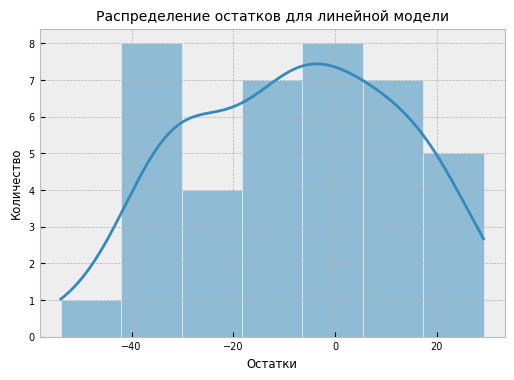

In [390]:
residuals = y_test - y_pred_lin

plt.figure(figsize = (6, 4))
sns.histplot(residuals, kde=True)
plt.title("Распределение остатков для линейной модели")
plt.xlabel("Остатки"), plt.ylabel("Количество")
plt.show()

График распределения остатков позволяет визуализировать разницу между реальными и предсказанными значениями Spending Score. Остаток вычисляется как разность между этими двумя величинами.

Интерпретация графика:
- Идеальное распределение: Если модель идеально подходит данным, остатки должны распределяться равномерно вокруг нуля (среднее значение равно нулю), образуя нормальное распределение (колоколообразную кривую).
- Отклонения от нормального распределения: Любые значительные отклонения от нормальной формы (например, асимметрия, длинные хвосты, кластеры остатков) указывают на проблемы с моделью. Например:
  - Асимметричное распределение может указывать на систематические ошибки в предсказаниях.
  - Большое количество больших положительных или отрицательных остатков говорит о том, что модель регулярно недооценивает или переоценивает значения.

Простая интерпретация:
Этот график помогает увидеть, насколько точно модель предсказывает значения. Если остатки равномерно распределены вокруг нуля, модель работает неплохо. Если наблюдаются сильные отклонения, это признак проблем с точностью модели.

## <a id='toc7_6_'></a>[Дополнительно: Кросс-валидация для оценки устойчивости линейной модели](#toc0_)

In [391]:
lin_cv_scores = cross_val_score(lin_reg, X_train_scaled, y_train, cv=5, scoring='r2')
print("Кросс-валидация (Линейная регрессия, R²):", lin_cv_scores)

Кросс-валидация (Линейная регрессия, R²): [ 0.14285989 -0.00449044 -0.16108338  0.14920608  0.04561792]


Кросс-валидация используется для оценки устойчивости модели, проверяя её производительность на различных участках данных. В данном случае кросс-валидация была выполнена с использованием 5-кратного разбиения (cv=5), и метрика качества оценивалась через коэффициент детерминации R².

Интерпретация результатов:
- Значение R²: Коэффициент детерминации измеряет долю дисперсии целевой переменной, которую объясняет модель. Значение R² варьируется от 0 до 1, где 1 означает идеальное соответствие модели данным, а 0 — отсутствие связи.
- Устойчивость модели: Важно смотреть на диапазон полученных значений R². Если значения сильно различаются, это может свидетельствовать о нестабильной работе модели на разных частях данных.

Простая интерпретация:
Кросс-валидация помогает проверить, насколько стабильно модель работает на новых данных. Если значения R² сильно варьируются, это может означать, что модель переобучена или недостаточно обобщаема.

**Вывод:** Анализ показал, что две модели линейная регрессия и случайный лес могут объяснить всего 2 и 8 процентов целевой переменной. Это низкие показатели, которые говорят о том, что прогнозы моделей далеки от истины. Основные признаки, вероятно, недостаточно сильно связаны с целевым показателем.

<a id='link_5'></a>
# <a id='toc8_'></a>[Вопрос 5. Какие аномалии и выбросы присутствуют в данных, и как они могут влиять на результаты анализа?](#toc0_)

Определим функцию для обнаружения выбросов

In [392]:
def find_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return series[(series < lower_bound) | (series > upper_bound)]

## <a id='toc8_1_'></a>[Определение выбросов для каждой переменной](#toc0_)

In [393]:
outliers_age = find_outliers(df['Age'])
outliers_income = find_outliers(df['Annual Income (k$)'])
outliers_score = find_outliers(df['Spending Score (1-100)'])

# вывод аномалий
print("Аномалии в Age:")
print(outliers_age)
print("\nАномалии в Annual Income:")
print(outliers_income)
print("\nАномалии в Spending Score:")
print(outliers_score)

Аномалии в Age:
Series([], Name: Age, dtype: int64)

Аномалии в Annual Income:
198    137
199    137
Name: Annual Income (k$), dtype: int64

Аномалии в Spending Score:
Series([], Name: Spending Score (1-100), dtype: int64)


Анализ выбросов: Годовой доход (`Annual Income (k$)`): Выбросы были обнаружены в двух наблюдениях с годовым доходом 137 тысяч долларов. Такие значения могут оказаться существенно больше среднего дохода в выборке и, следовательно, представлять собой выбросы, способные повлиять на модели машинного обучения.

Влияние выбросов на результаты анализа:
Выбросы могут оказывать значительное влияние на различные этапы анализа данных, особенно когда речь идет о моделях машинного обучения. Рассмотрим, каким образом выбросы в годовом доходе могут воздействовать на анализ:

1. Регрессии и предсказания:
   - Линейная регрессия и другие методы регрессии чувствительны к выбросам, поскольку они стремятся минимизировать сумму квадратов ошибок между предсказанными значениями и фактическими. Если в данных есть выбросы, такие точки могут смещать линию регрессии, делая её менее точной для основной массы наблюдений.
   - Для моделей типа Random Forest, хотя они и обладают устойчивостью к выбросам благодаря использованию деревьев решений, выбросы всё же могут повлиять на качество модели. Например, если некоторые деревья в случайном лесе будут строить свои решения вокруг выбросов, итоговая оценка будет хуже.

2. Метрики качества:
   - Коэффициент детерминации R² показывает долю дисперсии целевой переменной, которую объясняет модель. Выбросы могут снижать значение R², поскольку они часто находятся далеко от линии регрессии и увеличивают ошибку модели.
   - Средняя абсолютная ошибка (MAE) и среднеквадратичная ошибка (RMSE) также возрастают из-за выбросов, так как эти метрики измеряют разницу между предсказаниями и истинными значениями, включая выбросы.

3. Кросс-валидация:
   Результаты кросс-валидации показывают нестабильность модели линейной регрессии — значения R² варьируются от положительных до отрицательных, что подтверждает чувствительность модели к выбросам. Это может свидетельствовать о переобучении на тренировочном наборе данных.

Рекомендации:
Для повышения точности анализа рекомендуется либо удалить выбросы перед построением моделей, либо использовать робастные алгоритмы, которые менее подвержены влиянию выбросов (например, методы квантильной регрессии). Также стоит учитывать возможное наличие скрытых факторов, объясняющих высокие доходы, чтобы избежать удаления полезной информации.

## <a id='toc8_2_'></a>[Ящик с усами для демонстрации выбросов](#toc0_)

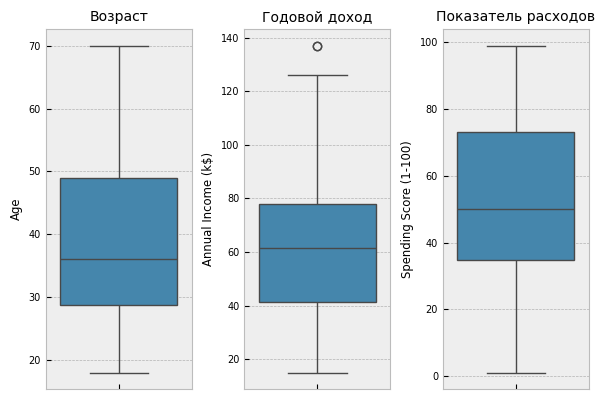

In [394]:
plt.figure(figsize = (6, 4))

plt.subplot(1, 3, 1)
sns.boxplot(y=df['Age'])
plt.title("Возраст")

plt.subplot(1, 3, 2)
sns.boxplot(y=df['Annual Income (k$)'])
plt.title("Годовой доход")

plt.subplot(1, 3, 3)
sns.boxplot(y=df['Spending Score (1-100)'])
plt.title("Показатель расходов")

plt.tight_layout()
plt.show()

## <a id='toc8_3_'></a>[График распределения для выделения выбросов показателя расходов относительно доходов](#toc0_)

(Text(0.5, 0, 'Годовой доход'), Text(0, 0.5, 'Показатель расходов'))

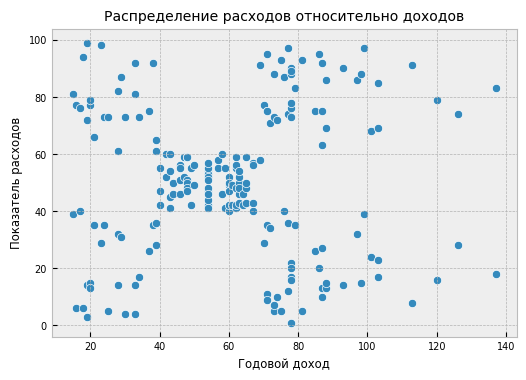

In [395]:
plt.figure(figsize = (6, 4))
sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)', data=df)
plt.title("Распределение расходов относительно доходов")
plt.xlabel('Годовой доход'), plt.ylabel('Показатель расходов')

## <a id='toc8_4_'></a>[Выделение точек-выбросов для годового дохода](#toc0_)

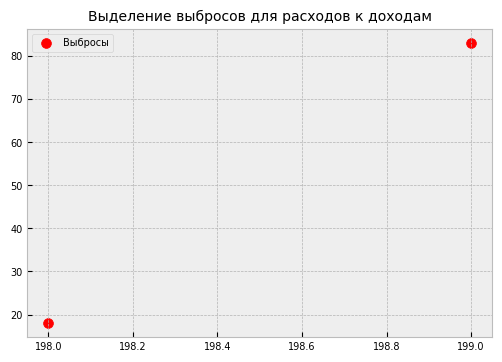

In [396]:
plt.figure(figsize = (6, 4))
plt.scatter(outliers_income.index, df.loc[outliers_income.index, 'Spending Score (1-100)'],
            color='red', label="Выбросы", s=50)
plt.title("Выделение выбросов для расходов к доходам")
plt.legend()
plt.show()

**Вывод:** В данных присутствуют выбросы в показателе годового дохода, поле `Annual Income (k$)`. Данные выбросы могут повлиять на результаты прогноза модели. Подробный ответ представлен выше в разделе с данным вопросом.

# <a id='toc9_'></a>[Итоги](#toc0_)

**Вопрос 1:** На какие сегменты можно разделить клиентов супермаркета?

Ответ: Клиентов супермаркета можно разделить с использованием оценки возраста и расходов на 3, 4 и 5 сегментов. Клиентов супермаркета также можно разделить с использованием оценки годового дохода и расходов на 5 сегментов. [Перейти в раздел вопроса](#link_1)

**Вопрос 2:** Какие зависимости существуют между возрастом, уровнем дохода и тратами клиентов?

Ответ: Зависимость между возрастом и годовым доходом практически отсутствует. С увеличением возраста доходы снижаются не значительно. Зависимость между возрастом и показателем расходов слабая отрицательная. Это означает, что с увеличением возраста расходы немного снижаются. Между годовым доходом и показателем расходов зависимость практически отсутствует. [Перейти в раздел вопроса](#link_2)

**Вопрос 3:** Как влияет пол на распределение доходов и покупательских оценок?

Ответ: Женщины имеют средний годовой доход около 59,25 тысяч долларов и мужчины имеют немного больший средний доход примерно 62,23 тысячи долларов. Это означает, что мужчины зарабатывают немного больше, чем женщины. Средний уровень расходов среди женщин равен 51,53 и среди мужчин показатель ниже и равен 48,51. Это означает, что женщины тратят немного больше денег, чем мужчины. [Перейти в раздел вопроса](#link_3)

**Вопрос 4:** Можно ли создать надёжную прогностическую модель для оценки показателя расходов на основе возраста, уровня дохода и пола? Какие факторы являются наиболее значимыми?

Ответ: Анализ показал, что две модели линейная регрессия и случайный лес могут объяснить всего 2 и 8 процентов целевой переменной. Это низкие показатели, которые говорят о том, что прогнозы моделей далеки от истины. Основные признаки, вероятно, недостаточно сильно связаны с целевым показателем. [Перейти в раздел вопроса](#link_4)

**Вопрос 5:** Какие аномалии и выбросы присутствуют в данных, и как они могут влиять на результаты анализа?

Ответ: В данных присутствуют выбросы в показателе годового дохода, поле `Annual Income (k$)`. Данные выбросы могут повлиять на результаты прогноза модели. Подробный ответ представлен выше в разделе с данным вопросом. [Перейти в раздел вопроса](#link_5)